In [23]:
# Setup and model reading code

import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette('hls', 8))

import torch
import torch.nn

from morpho_tagging.networks import *
from morpho_tagging.train import parser
from morpho_tagging.visualization_helper import *

def load_model_and_data(best_model, model_settings, word_vocab_path, char_vocab_path):
    device="cpu"
    load_params = parser.parse_args(["--training_type", "lm", "--data_path_ud", "dummy", "--save_dir", "dummy", "--pretrained_model", best_model, "--pretrained_settings", model_settings])

    with open(load_params.pretrained_settings) as settings_in:
        print("Loading model settings")
        settings_json = json.load(settings_in)
        for k in settings_json:
            if k != 'pretrained_model':
                setattr(load_params, k, settings_json[k])
            if k == "tagset_size":
                tagset_sizes = {}
                for a, v in settings_json[k].items():
                    tagset_sizes[int(a)]=v
                setattr(load_params, k, tagset_sizes)
            
    print(load_params)

    model = Tagger(load_params, device)
    model.load_state_dict(torch.load(load_params.pretrained_model, map_location=torch.device('cpu')))

    with open(char_vocab_path, 'rb') as vocab_in:
        char_vocab = pickle.load(vocab_in)

    with open(word_vocab_path, 'rb') as words_in:
        word_vocab = pickle.load(words_in)
    
    return model, char_vocab, word_vocab

In [2]:
# Word list for finding the nearest neighbors in the model's word embedding space
word_list = ['большой', 'большая', 'мужчина', "женщина", 'женщины', "Москва", "говорить", "говоришь", "меня", "мне", "тебя", "тебе", "весна", "этот", "это", 'этой', 'эта', 'быть', 'было', 'в', 'красный', 'красная', 'красном', '?', '.', "любовь", "любви", "любить", "любила", "сказать", "рассказывать", "разговор", "привет", "спасибо", "нет", "хорошо", "хороший", "Саша", "ночь", "день", "днём", "и", "а", "но", "ну", "я", "он", "его", "она", "ее", "её", 'Россия', "России", "здравствуйте", "здравствуй", "книга", "книги", "собака", "собак", "собаки", "кошка", "кошки", "кошек", "когда", "где", "который", "которой", 'просить', "прошу", "спрошу", "спросить", "писать", "пишу", "пишет", "любить", "любишь", "бросить", "встретить", "встречу", "вижу", "видишь", "видит", "ответ", "отвечу", "отвечаю", "тихий", "тише", "много", "меньше"]

# Best BiLSTM model analysis

In [3]:
# Paths to model outputs
model_root = "/home/virginia/workspace/CS682_NNs_Nerual_Char_Models_Russian/language_models"
model_name = "bilstm_batch20_dropout0.50_charembedsize50_learningrate0.001_hiddensize200"
best_model = f"{model_root}/{model_name}/tagger_ru_data_19_Nov_2021_15_21_41_best"
model_settings = f"{model_root}/{model_name}/tagger_ru_settings_19_Nov_2021_15_21_41"
char_vocab_path = f"{model_root}/{model_name}/tagger_ru_charvocab_19_Nov_2021_15_21_41"
word_vocab_path = f"{model_root}/{model_name}/tagger_ru_wordvocab_19_Nov_2021_15_21_41"


bilstm_model, bilstm_char_vocab, bilstm_word_vocab = load_model_and_data(best_model, model_settings, word_vocab_path, char_vocab_path)

Loading model settings
Namespace(batch_size=20, char_conv_act='relu', char_embedding_size=50, char_filter_sizes=[1, 2, 3, 4, 5, 6], char_gram=1, char_number_of_filters=[25, 50, 75, 100, 125, 150], char_rec_num_units=200, char_type='bilstm', char_vocab_size=185, data_path_ud='../CS682_NNs_Nerual_Char_Models_Russian/data', dropout_frac=0.5, language='ru', lm_hidden_size=100, lm_num_layers=1, lr=0.001, num_epochs=10, pad_index=0, pretrained_model='/home/virginia/workspace/CS682_NNs_Nerual_Char_Models_Russian/language_models/bilstm_batch20_dropout0.50_charembedsize50_learningrate0.001_hiddensize200/tagger_ru_data_19_Nov_2021_15_21_41_best', pretrained_settings=None, save_dir='../CS682_NNs_Nerual_Char_Models_Russian/language_models/bilstm_batch20_dropout0.50_charembedsize50_learningrate0.001_hiddensize200', save_file='tagger_ru_', tagset_size={0: 20}, training_type='lm', unique_words=0, word_vocab_size=140768)


In [4]:
# Get CharEmbeddings from model 
bilstm_char_embedding_weights = bilstm_model.char_embeddings.weight.detach().numpy()

bilstm_char_plot_df, bilstm_pca, bilstm_tsne = build_visualization_dataframe(bilstm_char_embedding_weights, bilstm_char_vocab)

/home/virginia/miniconda3/envs/682_final_proj/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/virginia/miniconda3/envs/682_final_proj/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


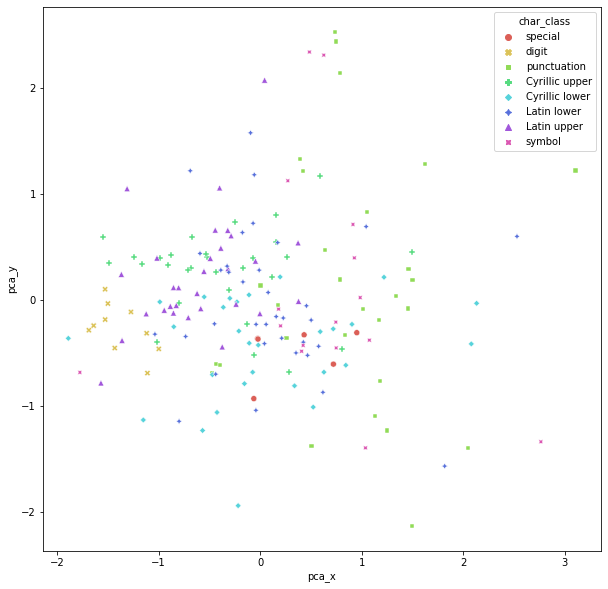

In [26]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data = bilstm_char_plot_df, x="pca_x", y="pca_y", hue="char_class", style='char_class')

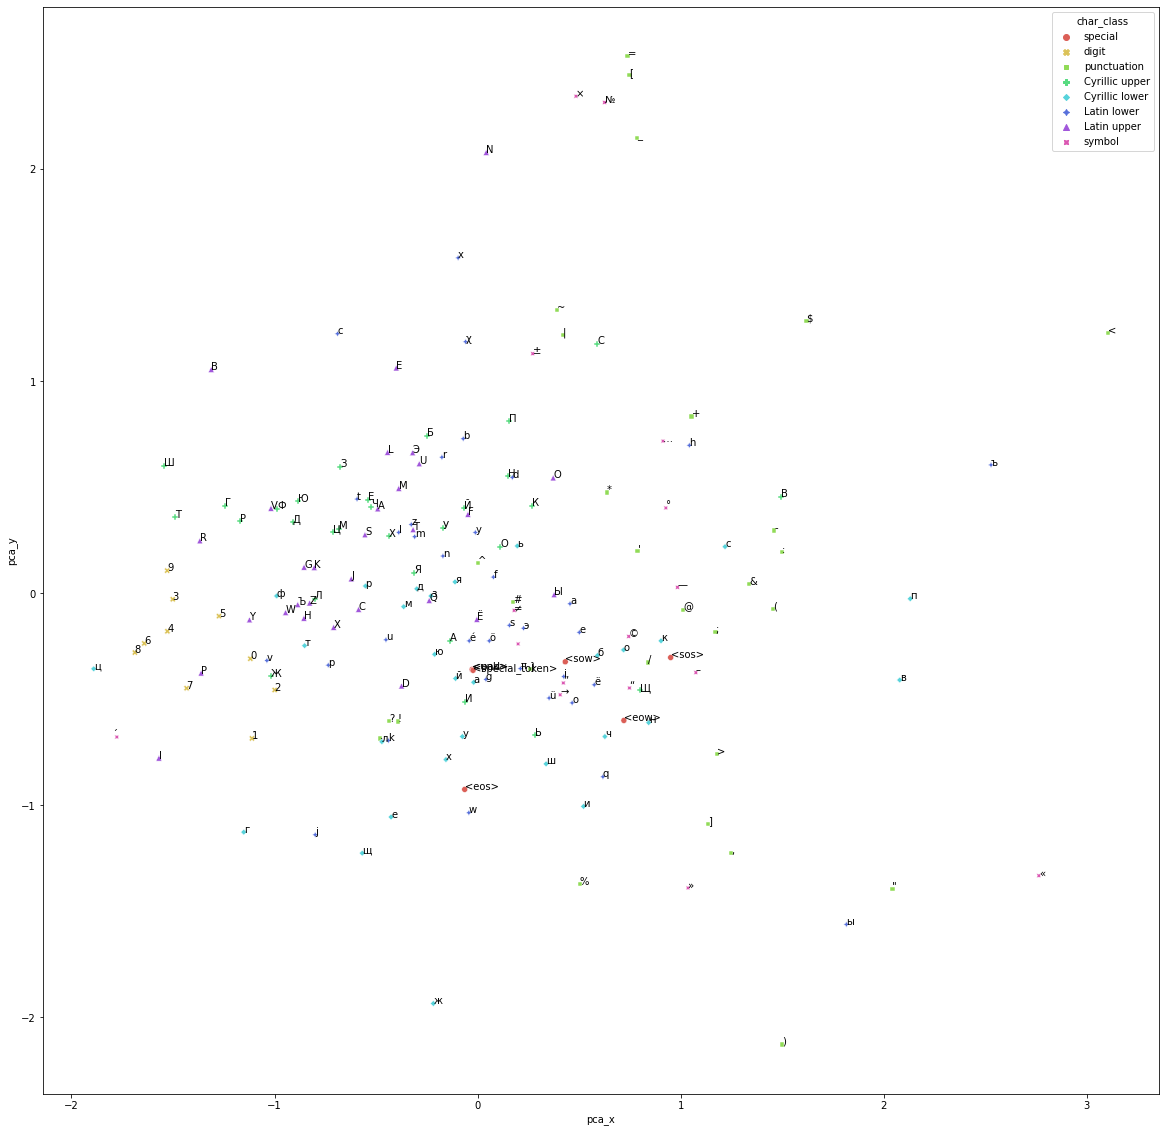

In [25]:
plt.figure(figsize=(20,20))
ax = sns.scatterplot(data = bilstm_char_plot_df, x="pca_x", y="pca_y", hue="char_class", style='char_class')
for k, char_idx in bilstm_char_vocab.char_to_index.items():
    ax.text(bilstm_pca[char_idx][0], bilstm_pca[char_idx][1], k)

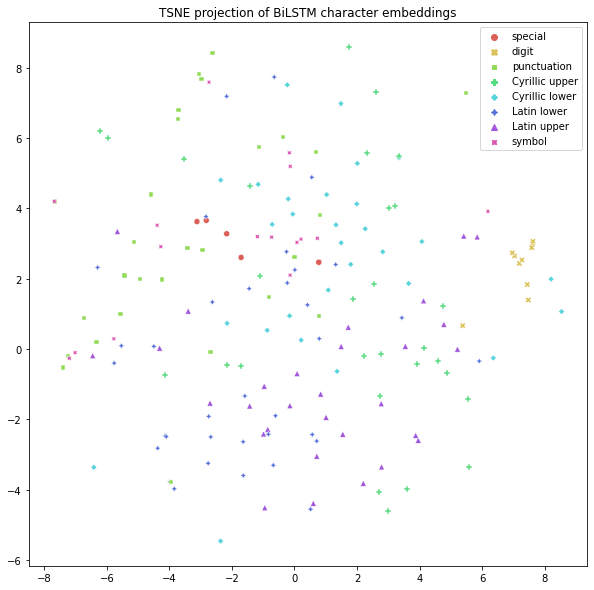

In [24]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data = bilstm_char_plot_df, x="tsne_x", y="tsne_y", hue="char_class", style='char_class')
#for k, char_idx in char_vocab.char_to_index.items():
#    ax.text(char_tsne_proj[char_idx][0], char_tsne_proj[char_idx][1], k)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set(title="TSNE projection of BiLSTM character embeddings")
ax.get_legend().set_title("Character class")
plt.legend(loc='upper right')

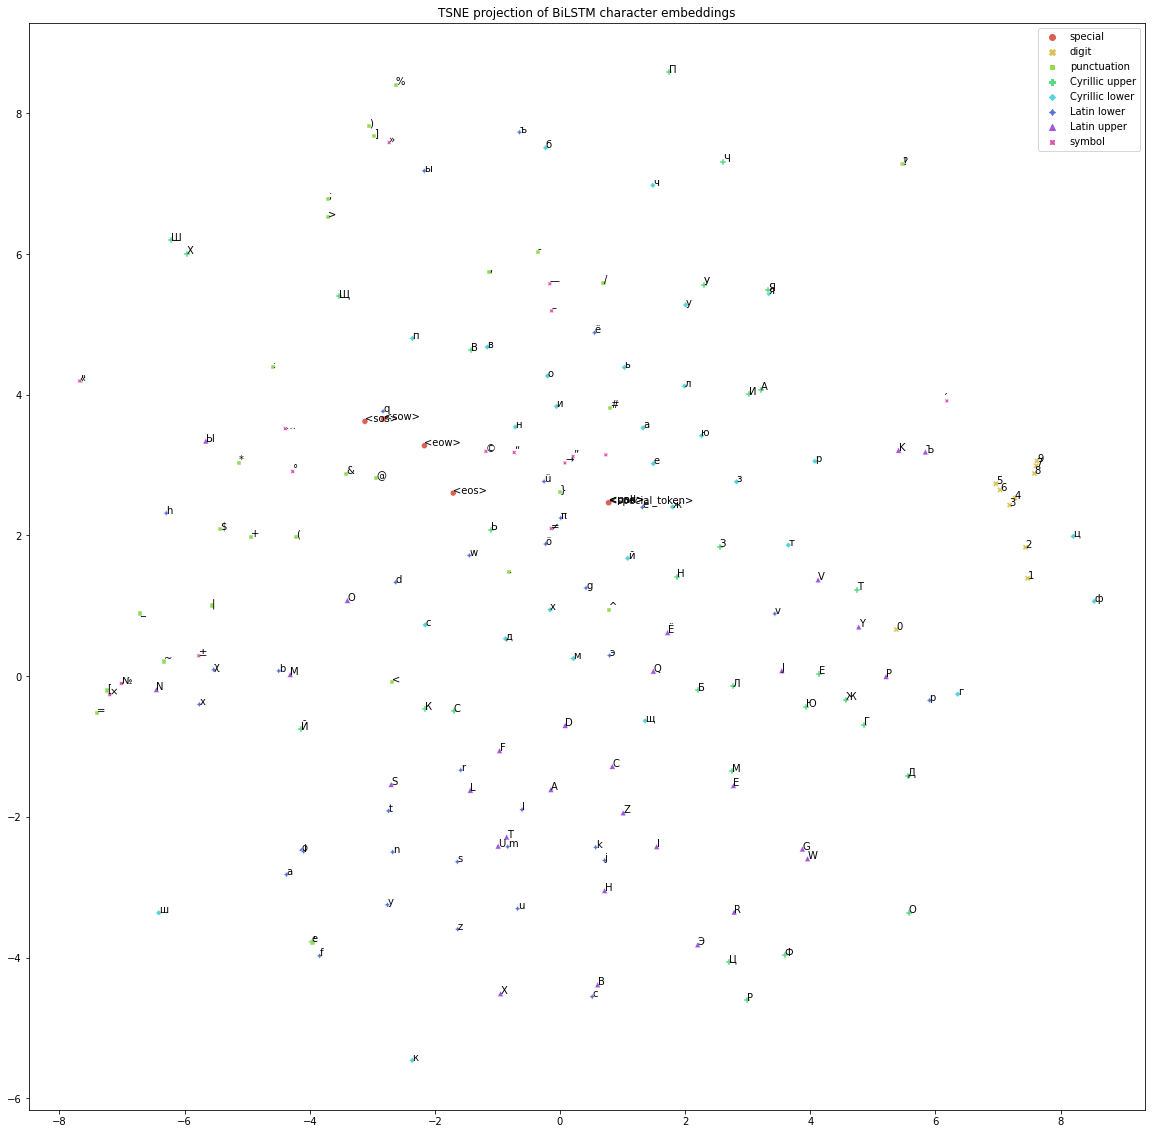

In [27]:
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(data = bilstm_char_plot_df, x="tsne_x", y="tsne_y", hue="char_class", style='char_class')
for k, char_idx in bilstm_char_vocab.char_to_index.items():
    ax.text(bilstm_tsne[char_idx][0], bilstm_tsne[char_idx][1], k)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set(title="TSNE projection of BiLSTM character embeddings")
ax.get_legend().set_title("Character class")
plt.legend(loc='upper right')

In [9]:
bilstm_word_embeddings = get_word_embedding_input_batch(bilstm_word_vocab, bilstm_char_vocab, bilstm_model, 400)

Word to index size: 140765
Index to word size: 140765
Those two numbers should match
(140768, 101)
140768
Batch from 0 to 352
Batch from 8800 to 9152
Batch from 17600 to 17952
Batch from 26400 to 26752
Batch from 35200 to 35552
Batch from 44000 to 44352
Batch from 52800 to 53152
Batch from 61600 to 61952
Batch from 70400 to 70752
Batch from 79200 to 79552
Batch from 88000 to 88352
Batch from 96800 to 97152
Batch from 105600 to 105952
Batch from 114400 to 114752
Batch from 123200 to 123552
Batch from 134450 to 134801
Embedding shape: (140768, 400)


In [10]:
for w in word_list: 
    get_most_similar_words(w, bilstm_word_embeddings, bilstm_word_vocab)

Word: большой Index: 577
['небольшой', 'пребольшой', 'Небольшой', 'больной', 'белой', 'светлой', 'сверхбольшой', 'беговой', 'Большой', 'командной']
Word: большая Index: 1347
['бОльшая', 'небольшая', 'наибольшая', 'пребольшая', 'нехорошая', 'Небольшая', 'Нехорошая', 'хорошая', 'Хорошая', 'уменьшая']
Word: мужчина Index: 2209
['мужика', 'мамина', 'мезона', 'муженька', 'колонна', 'филина', 'малина', 'камина', 'дружина', 'маменька']
Word: женщина Index: 603
['ангина', 'Горемыкина', 'Курникова', 'живехонька', 'апельсина', 'Аврамова', 'машина', 'животновода', 'железяки', 'желанна']
Word: женщины Index: 3939
['желтизны', 'желательны', 'железы', 'желтозёмы', 'термины', 'балясины', 'женаты', 'бирючины', 'грузины', 'жилеты']
Word: Москва Index: 4677
['Кудимова', 'Мосса', 'Минфина', 'Юшенкова', 'Шмакова', 'Логвинова', 'Грекова', 'Рафикова', 'Ломоносова', 'Михайловна']
Word: говорить Index: 639
['говорите', 'говорило', 'говорят', 'говорили', 'говорила', 'говорится', 'говоришь', 'говните', 'Говорит

# Best CNN model analysis

In [11]:
# Paths to model outputs
cnn_model_root = "/home/virginia/workspace/CS682_NNs_Nerual_Char_Models_Russian/language_models"
cnn_model_name = "conv_batch20_dropout0.25_charembedsize50_learningrate0.001_activationleakyrelu"
best_cnn_model = f"{cnn_model_root}/{cnn_model_name}/tagger_ru_data_17_Nov_2021_02_07_09_best"
cnn_model_settings = f"{cnn_model_root}/{cnn_model_name}/tagger_ru_settings_17_Nov_2021_02_07_09"
cnn_char_vocab_path = f"{cnn_model_root}/{cnn_model_name}/tagger_ru_charvocab_17_Nov_2021_02_07_09"
cnn_word_vocab_path = f"{cnn_model_root}/{cnn_model_name}/tagger_ru_wordvocab_17_Nov_2021_02_07_09"

cnn_model, cnn_char_vocab, cnn_word_vocab = load_model_and_data(best_cnn_model, cnn_model_settings, cnn_word_vocab_path, cnn_char_vocab_path)

Loading model settings
Namespace(batch_size=20, char_conv_act='leakyrelu', char_embedding_size=50, char_filter_sizes=[1, 2, 3, 4, 5, 6], char_gram=1, char_number_of_filters=[25, 50, 75, 100, 125, 150], char_rec_num_units=100, char_type='conv', char_vocab_size=185, data_path_ud='../CS682_NNs_Nerual_Char_Models_Russian/data', dropout_frac=0.25, language='ru', lm_hidden_size=100, lm_num_layers=1, lr=0.001, num_epochs=10, pad_index=0, pretrained_model='/home/virginia/workspace/CS682_NNs_Nerual_Char_Models_Russian/language_models/conv_batch20_dropout0.25_charembedsize50_learningrate0.001_activationleakyrelu/tagger_ru_data_17_Nov_2021_02_07_09_best', pretrained_settings=None, save_dir='../CS682_NNs_Nerual_Char_Models_Russian/language_models/conv_batch20_dropout0.25_charembedsize50_learningrate0.001_activationleakyrelu', save_file='tagger_ru_', tagset_size={0: 20}, training_type='lm', unique_words=0, word_vocab_size=140768)


In [12]:
# Get CharEmbeddings from model 
cnn_char_embedding_weights = cnn_model.char_embeddings.weight.detach().numpy()
cnn_char_plot_df, cnn_pca, cnn_tsne = build_visualization_dataframe(cnn_char_embedding_weights, cnn_char_vocab)

/home/virginia/miniconda3/envs/682_final_proj/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/virginia/miniconda3/envs/682_final_proj/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[Text(0.5, 1.0, 'PCA projection of CNN character embeddings')]

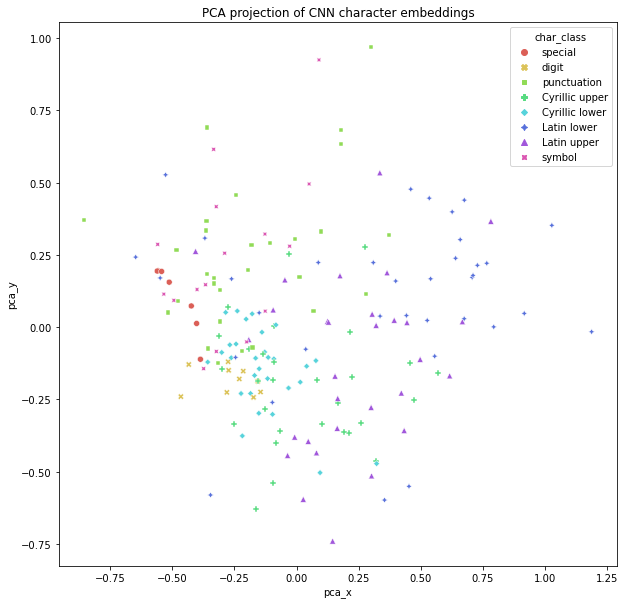

In [28]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data = cnn_char_plot_df, x="pca_x", y="pca_y", hue="char_class", style='char_class')
ax.set(title="PCA projection of CNN character embeddings")
#for k, char_idx in cnn_char_vocab.char_to_index.items():
#    ax.text(char_pca_proj[char_idx][0], char_pca_proj[char_idx][1], k)

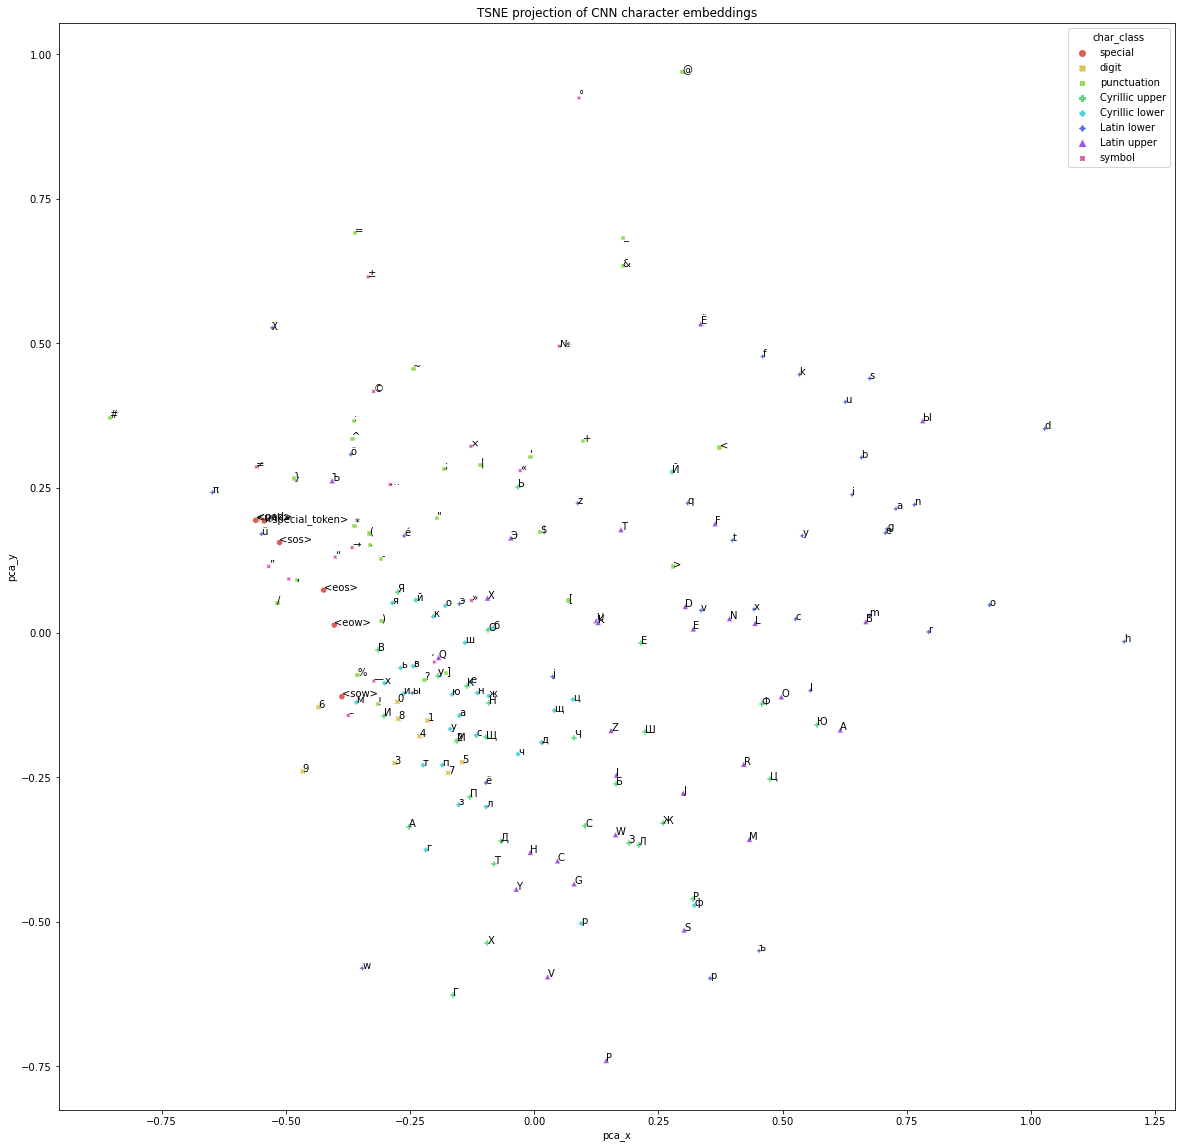

In [29]:
plt.figure(figsize=(20,20))
ax = sns.scatterplot(data = cnn_char_plot_df, x="pca_x", y="pca_y", hue="char_class", style='char_class')
ax.set(title="TSNE projection of CNN character embeddings")
for k, char_idx in cnn_char_vocab.char_to_index.items():
    ax.text(cnn_pca[char_idx][0], cnn_pca[char_idx][1], k)

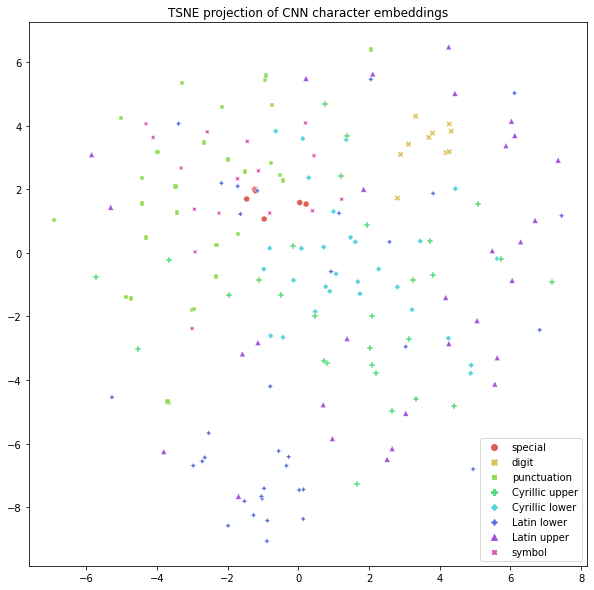

In [30]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data = cnn_char_plot_df, x="tsne_x", y="tsne_y", hue="char_class", style='char_class')
#for k, char_idx in cnn_char_vocab.char_to_index.items():
#    ax.text(cnn_tsne[char_idx][0], cnn_tsne[char_idx][1], k)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set(title="TSNE projection of CNN character embeddings")
ax.get_legend().set_title("Character class")
plt.legend(loc='lower right')

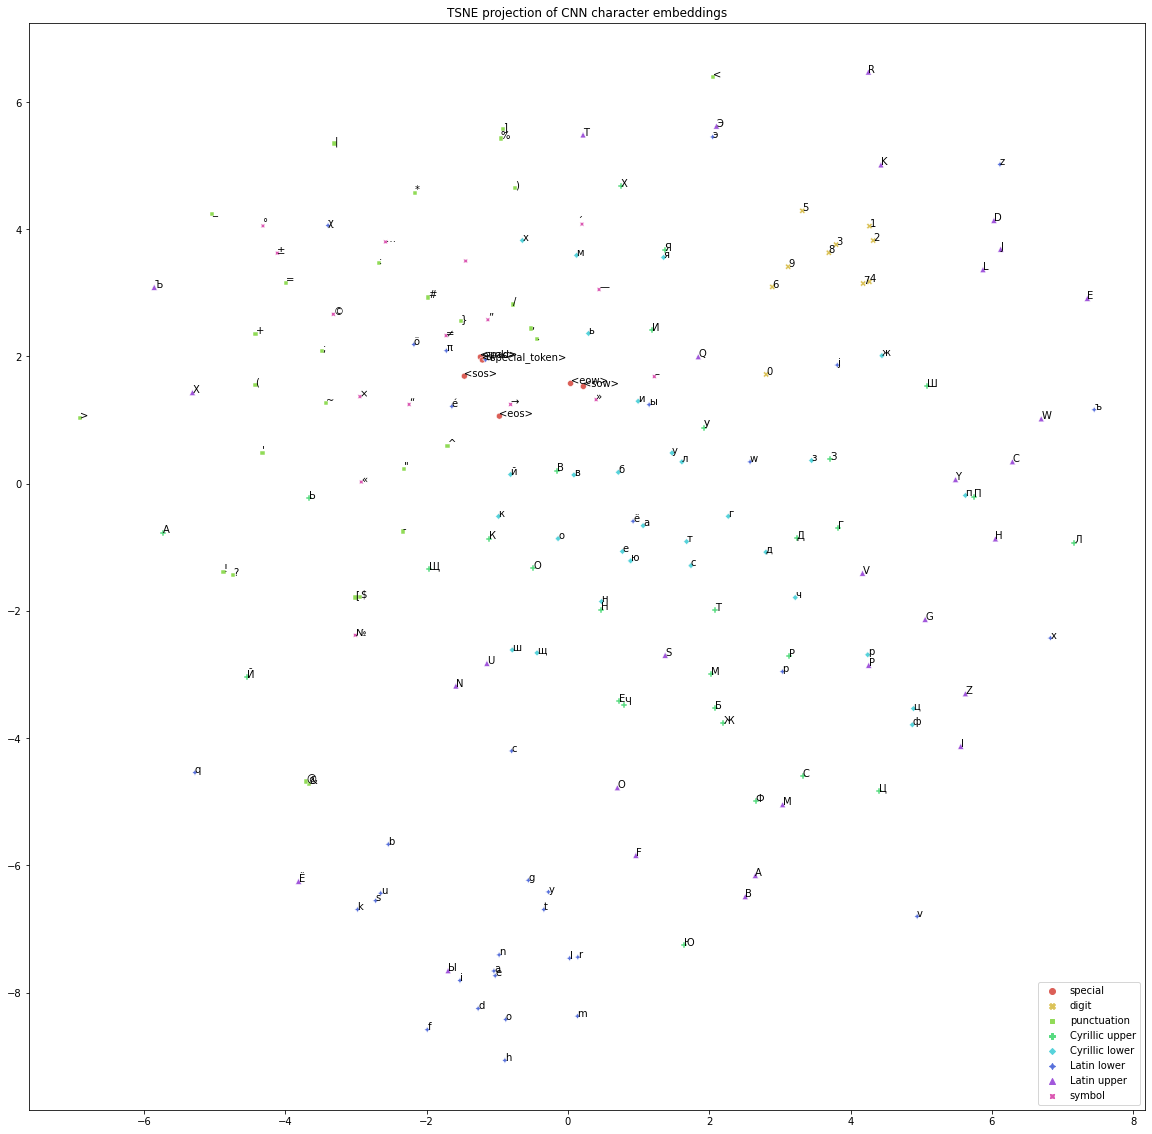

In [31]:
plt.figure(figsize=(20, 20))
ax = sns.scatterplot(data = cnn_char_plot_df, x="tsne_x", y="tsne_y", hue="char_class", style='char_class')
for k, char_idx in cnn_char_vocab.char_to_index.items():
    ax.text(cnn_tsne[char_idx][0], cnn_tsne[char_idx][1], k)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set(title="TSNE projection of CNN character embeddings")
ax.get_legend().set_title("Character class")
plt.legend(loc='lower right')

In [17]:
cnn_word_embeddings = get_word_embedding_input_batch(cnn_word_vocab, cnn_char_vocab, cnn_model, 525)

Word to index size: 140765
Index to word size: 140765
Those two numbers should match
(140768, 101)
140768
Batch from 0 to 269
Batch from 13450 to 13719
Batch from 19900 to 20168
Batch from 26600 to 26868
Batch from 33300 to 33568
Batch from 40000 to 40268
Batch from 46700 to 46968
Batch from 53400 to 53668
Batch from 60100 to 60368
Batch from 66800 to 67068
Batch from 73500 to 73768
Batch from 80200 to 80468
Batch from 86900 to 87168
Batch from 93600 to 93868
Batch from 100300 to 100568
Batch from 107000 to 107268
Batch from 113700 to 113968
Batch from 120400 to 120668
Batch from 127100 to 127368
Batch from 133800 to 134068
Batch from 140500 to 140768
Embedding shape: (140768, 525)


In [18]:
for w in word_list: 
    get_most_similar_words(w, cnn_word_embeddings, cnn_word_vocab)

Word: большой Index: 577
['небольшой', 'Небольшой', 'сверхбольшой', 'дельной', 'начальной', 'незначительной', 'необязательной', 'печальной', 'сдельной', 'стельной']
Word: большая Index: 1347
['бОльшая', 'небольшая', 'наибольшая', 'Небольшая', 'тяжелейшая', 'Пожелтевшая', 'бывшая', 'новейшая', 'ставшая', 'вручившая']
Word: мужчина Index: 2209
['города', 'пустынна', 'Нигматуллина', 'тулупа', 'заминка', 'гусака', 'горку', 'коммуналка', 'эллина', 'мужчину']
Word: женщина Index: 603
['женщину', 'колготина', 'сплина', 'лещина', 'эллина', 'дельфина', 'инсулина', 'начфина', 'слеза', 'сингониума']
Word: женщины Index: 3939
['мины', 'общины', 'коммуны', 'лавины', 'паутины', 'балясины', 'длинны', 'дельфины', 'бегуны', 'половины']
Word: Москва Index: 4677
['Москва-река', 'Морозова', 'Мордюкова', 'Мольера', 'Кириллова', 'Диброва', 'Чувства', 'Мосгорсправка', 'Кольцова', 'Кирова']
Word: говорить Index: 639
['говорили', 'говорят', 'говорит', 'говорила', 'уговорили', 'уговорила', 'говорите', 'оговорит